In [1]:
runner_path = "/home/alexmak123/neurone"
config_path = "/home/alexmak123/neurone/experiments/endonet_1class_plasmatic_search_168_v4/config.json"
engine_type = "gpu"
device_number = 4
tiles_directory_in_str = "/home/alexmak123/result_plasmatic_dataset_162_with_non_plasmatic_v2/test/images"
tiles_labels_directory_in_str = "/home/alexmak123/result_plasmatic_dataset_162_with_non_plasmatic_v2/test/labels"


import os
if (engine_type == "gpu"):
    #here we choose on which tesla to run
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = str(device_number)
    !export 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'

    
import os
import argparse
import json
from animus.torch.engine import CPUEngine, DDPEngine, DPEngine, GPUEngine, XLAEngine
from neurone.utils.general import load_yaml
import torch
from datetime import datetime 
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from PIL import Image, ImageDraw
from skimage.io import imread, imsave, imshow
import cv2
%matplotlib inline

In [2]:
%cd $tiles_directory_in_str

index_image_dict = {}

alb_transforms = A.Compose([A.augmentations.Resize(1024, 1024)])
def import_tiles_from_directory_and_convert_them (tiles_directory_in_str):
    j = 0
    directory = os.fsencode(tiles_directory_in_str)
    converted_images = []
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if (filename.endswith(".png") or filename.endswith(".jpg")):
            basename = os.path.splitext(filename)[0]
            index_image_dict[j] = basename
            myTile = np.array(Image.open(filename).convert('RGB'))
            myTile = alb_transforms(image=myTile)["image"]
            converted_images.append(myTile)
            j += 1
            continue
        else:
            continue
    return np.array(converted_images)

converted_images = import_tiles_from_directory_and_convert_them (tiles_directory_in_str)

/home/alexmak123/result_plasmatic_dataset_162_with_non_plasmatic_v2/test/images


In [3]:
validation_image_dict = {}
for key_image, value_image in index_image_dict.items():
    validation_image_dict[value_image] = []

In [4]:
#create a dict with coordinates of plasmatic cells of the image, validated by doctors
#Note: always false here, this code is for validation and accuracy count
we_have_Validation_Plasmatic_Cells = True

if (we_have_Validation_Plasmatic_Cells):
    tiles_directory_in_str = tiles_labels_directory_in_str
    %cd $tiles_directory_in_str
    directory = os.fsencode(tiles_directory_in_str)
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if (filename.endswith(".txt")):
            basename = os.path.splitext(filename)[0]
            validation_image_dict[basename] = []
            f = open(filename)
            for line in f:
                splited_line = line.split()
                if (splited_line[2] == '0'):
                    x = int(round(float(splited_line[0])))
                    y = int(round(float(splited_line[1])))
                    validation_image_dict[basename].append((x, y))

/home/alexmak123/result_plasmatic_dataset_162_with_non_plasmatic_v2/test/labels


In [5]:
assert (len(index_image_dict) == len(validation_image_dict))
result_dict = {k: validation_image_dict[v] for k, v in index_image_dict.items() if v in validation_image_dict}

In [6]:
# Runners
from neurone.runners.detection import BaseDetectionRunner, HeatmapDetectionRunner
from neurone.runners.segmentation import BaseSegmentationRunner
from neurone.runners.gridsearch import GridSearchRunner


E2E = {
    "cpu": CPUEngine,
    "gpu": GPUEngine,
    "dp": DPEngine,
    "ddp": DDPEngine,
    "xla": XLAEngine,
}


with open(config_path, "r") as config_file:
        config = json.load(config_file)
config["train"]["engine"] = engine_type

if config["train"]["deterministic"]:
    torch.use_deterministic_algorithms(config["train"]["deterministic"])
logging_dir = os.path.join(config["train"]["save_dir"], config["train"]["experiment_name"])
    
runner = globals()[config["model"]["runner"]](engine=E2E[engine_type](
    log_with="tensorboard", logging_dir=logging_dir), config=config)

runner._setup_model()
runner.model.eval()

HeatmapDetector(
  (heatmap_model): UnetPlusPlus(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [7]:
#if we have gpu, we should run on cuda
if (engine_type == "gpu"):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    runner.model.to(device)
    
import sys
import time 

#our data to tensor
image_torch = torch.tensor(converted_images)
#image_torch = torch.unsqueeze(image_torch, 0)
image_torch = image_torch.permute(0, 3, 1, 2) 
image_torch = image_torch.float()
image_torch -= torch.tensor([config["data"]["norm_mean"][0], config["data"]["norm_mean"][1], config["data"]["norm_mean"][2]]).reshape(-1, 1, 1)
image_torch /= torch.tensor([config["data"]["norm_std"][0], config["data"]["norm_std"][1], config["data"]["norm_std"][2]]).reshape(-1, 1, 1)

if (engine_type == "cpu"):
    all_keypoints = runner.model(image_torch)["keypoints"]
    #all_confidences = runner.model(image_torch)["confidences"]

    
#amount of torch elements for a batch
#batch_size=2 is maximum for teslat4
batch_size = 2
if (engine_type == "gpu"):
    start = time.time() 
    all_keypoints = []
    #all_confidences = []
    splited_torch = torch.split(image_torch, batch_size)
    torch.cuda.empty_cache()
    i = 1
    num_iterations = int (image_torch.shape[0] / batch_size)
    
    for batch_torch in splited_torch:
        print ("iteration : ", i, "/", num_iterations)
        batch_torch = batch_torch.to(device)
        keypoint = np.array(runner.model(batch_torch)["keypoints"])
        all_keypoints.append(keypoint)
        #confidence = np.array(runner.model(batch_torch)["confidences"])
        #all_confidences.append(confidence) 
        i += 1
        del batch_torch
        
    end = time.time() - start
    print ("time, working on gpu", end)
    
#split keypoints of all tiles to array of selected colums with x_coords, y_coords and classes of all tiles
if (engine_type == "cpu"):
    j = 0
    selected_columns_array = []
    for index_tile in range(converted_images.shape[0]):
        selected_columns = []
        while (j < all_keypoints.shape[0] and all_keypoints[j][0] == index_tile):
            selected_columns.append([float(all_keypoints[j][1]), float(all_keypoints[j][2]), float(all_keypoints[j][3])])
            j += 1
        selected_columns_array.append(np.array(selected_columns))

if (engine_type == "gpu"):
    selected_columns_array = []
    for batch_keypoints in all_keypoints:
        j = 0
        for index_tile in range(batch_size):
            selected_columns = []
            while (j < batch_keypoints.shape[0] and batch_keypoints[j][0] == index_tile):
                selected_columns.append([float(batch_keypoints[j][1]), float(batch_keypoints[j][2]), float(batch_keypoints[j][3])])
                j += 1
            selected_columns_array.append(np.array(selected_columns))

iteration :  1 / 172
iteration :  2 / 172
iteration :  3 / 172
iteration :  4 / 172
iteration :  5 / 172
iteration :  6 / 172
iteration :  7 / 172
iteration :  8 / 172
iteration :  9 / 172
iteration :  10 / 172
iteration :  11 / 172
iteration :  12 / 172
iteration :  13 / 172
iteration :  14 / 172
iteration :  15 / 172
iteration :  16 / 172
iteration :  17 / 172
iteration :  18 / 172
iteration :  19 / 172
iteration :  20 / 172
iteration :  21 / 172
iteration :  22 / 172
iteration :  23 / 172
iteration :  24 / 172
iteration :  25 / 172
iteration :  26 / 172
iteration :  27 / 172
iteration :  28 / 172
iteration :  29 / 172
iteration :  30 / 172
iteration :  31 / 172
iteration :  32 / 172
iteration :  33 / 172
iteration :  34 / 172
iteration :  35 / 172
iteration :  36 / 172
iteration :  37 / 172
iteration :  38 / 172
iteration :  39 / 172
iteration :  40 / 172
iteration :  41 / 172
iteration :  42 / 172
iteration :  43 / 172
iteration :  44 / 172
iteration :  45 / 172
iteration :  46 / 1

In [8]:
import matplotlib.pyplot as plt
import numpy as np


algo_image_dict = {}
for img_index in range(len(converted_images)):
    algo_image_dict[img_index] = []
    
    
for i in range(len(converted_images)):
    # Create a new figure for each image
    #fig = plt.figure()
    
    # Draw circles on the image
    for dot_center in selected_columns_array[i]:
        if (dot_center[2] == 0):
            #cv2.circle(converted_images[i], (round(dot_center[0]), round(dot_center[1])), 4, (255,0,0), -1)
            algo_image_dict[i].append(((round(dot_center[0]), round(dot_center[1]))))
        if (dot_center[2] == 1):
            #cv2.circle(converted_images[i], (round(dot_center[0]), round(dot_center[1])), 4, (0, 0, 255), -1)
            
    # Convert the image to PIL format and display it
    #PIL_image = Image.fromarray(converted_images[i].astype('uint8'), 'RGB')
    #plt.imshow(PIL_image)
#plt.show()


IndentationError: expected an indented block (2782996025.py, line 25)

In [12]:
#ConvexHull
#Is used to find clusters of dots on the entire slide
#We add median filter to reduce some noise 
#We use laplacian filter for better precision 
plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["figure.autolayout"] = True


#parametrs that we can change 
global_median_filter_size = 17
global_treshold = 165
center_kernel_value = -8
global_noise_threshold = 20
amount_of_dots_in_the_center = 1


#we initialize the dictionary, where each image from converted_images is assigned a None branch
algo_image_dict = {}
for img_index in range(len(converted_images)):
    algo_image_dict[img_index] = []
    

#def that gets rid of hulls that are noise 
def reduce_noise(hulls, noise_threshold = global_noise_threshold):
    hulls_without_noise = []
    for curr_hull in hulls:
        if (cv2.arcLength(curr_hull, True) >= noise_threshold):
            hulls_without_noise.append(curr_hull)
            
    return hulls_without_noise


#def that removes duplicates of the contours (it is happend because cv2.findContours returns clockwise and non-clockwise oriented contours) 
def get_only_positive_oriented_contours(contours):
    positive_oriented_contours = []
    for curr_contour in contours:
        if (cv2.contourArea(curr_contour, 1) <= 0 and cv2.contourArea(curr_contour, 0) >= 0):
            positive_oriented_contours.append(curr_contour)
    
    return positive_oriented_contours


#def that groups convex hulls in clusters of nested convex hulls (presented as a graph)
def group_convex_hulls(hulls):
    hierarchy = []
    for i in range(len(hulls)):
        #-1 stands for absence of the parent, this means that this convex hull is the outermost of the cell
        parent = -1
        for j in range(len(hulls)):
            if i == j:
                continue
            if cv2.pointPolygonTest(hulls[j], tuple(hulls[i][0][0]), False) >= 0:
                parent = j
                break
        hierarchy.append([i, parent])
    return hierarchy


#def that finds closest to outer hull, inner hull (if exists)
def find_closest_inner_hull(hierarchy, outer_hull_index):
    inner_hull_index = -2
    for (index, parent) in hierarchy : 
        if (parent == outer_hull_index):
            inner_hull_index = index
            break
            
    return inner_hull_index   


#def that counts mean hsv color of points, bounded by inner(if exists) and outer convex hull 
def coordinates_of_target_pixels_between_two_hulls(curr_picture, hulls, hierarchy, outer_hull_index):
    cv2.fillConvexPoly(curr_picture, hulls[outer_hull_index], (255, 0, 0))
    
    #lets find closest to outer hull, inner hull index (if it's -2, then we don't have an inner_hull)
    inner_hull_index = find_closest_inner_hull(hierarchy, outer_hull_index)
    if (inner_hull_index != -2): 
        cv2.fillConvexPoly(curr_picture, hulls[inner_hull_index], (0, 255, 0))
    
    target_value = (255, 0, 0)
    coordinates_of_target_pixels = []
    #quite seriously increases the running time of our program, it is better not to use it if it is not necessary
    for y in range(curr_picture.shape[0]):
        for x in range(curr_picture.shape[1]):
            if np.all(curr_picture[y, x] == target_value):
                coordinates_of_target_pixels.append((x, y))
                
    # Displaying the image
    plt.imshow(curr_picture.astype('uint8'), vmin=0, vmax=255)
    #plt.show()
    return coordinates_of_target_pixels


#def that counts hsv color of target_pixels in the original image
import colorsys
def count_hsv(original_image, coordinates_of_target_pixels):
    pixels = []
    for (y,x) in coordinates_of_target_pixels:
        pixels.append(original_image[x][y])
    
    rgb_mean = np.mean(pixels, axis = 0)
    (rgb_mean[0], rgb_mean[1], rgb_mean[2]) = (rgb_mean[0] / float(255), rgb_mean[1] / float(255), rgb_mean[2] / float(255))
    hsv = colorsys.rgb_to_hsv(rgb_mean[0], rgb_mean[1], rgb_mean[2])
    hsv = (int(hsv[0] * 179), int(hsv[1] * 255), int(hsv[2] * 255))
    
    return hsv


#def that counts the amount of stroma cells inside the convex hull. If there is one cell, then we will say that this cell is plasmatic
def count_the_amount_of_cells_inside_the_convex_hull (keypoints_for_this_img, hulls, outer_hull_index):
    amount_of_cells = 0
    outer_hull = hulls[outer_hull_index]
    center_keypoints = []
    for keypoint in keypoints_for_this_img:
        if (keypoint[2] == 0):
            x = keypoint[0]
            y = keypoint[1]
            distances = cv2.pointPolygonTest(outer_hull, (x,y), measureDist=False)
            if (distances >= 0):
                amount_of_cells += 1
                center_keypoints.append([x,y])
            
    return center_keypoints, amount_of_cells 


#def that is our main convex hull function 
def convex_hull_for_showing(images_list, path_to_save, median_filter_size = global_median_filter_size):
    hsv_brown_cells = []
    for i in range(len(images_list)):
        
        keypoints_for_this_img = selected_columns_array[i]
        
        median_image  = cv2.medianBlur(images_list[i], median_filter_size)
        
        img_grey = cv2.cvtColor(median_image, cv2.COLOR_BGR2GRAY)
        (thresh, blackAndWhiteImage) = cv2.threshold(img_grey, global_treshold, 255, cv2.THRESH_BINARY)
        kernel = np.array([[0,1,0], [1,center_kernel_value,1], [0,1,0]])
        img = cv2.filter2D(blackAndWhiteImage, -1, kernel)
        
        contours,_  = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 
        
        #get rid of duplication
        contours = get_only_positive_oriented_contours(contours)
        
        #count hulls
        hulls = []
        img_hulls_and_contours = np.zeros(images_list[i].shape)
        for j in range(len(contours)):
            cv2.drawContours(img_hulls_and_contours, contours, j, (0, 255, 0), 1, 8)
            hulls.append(cv2.convexHull(contours[j], False))
            
        #reduce noise in the hulls
        hulls = reduce_noise(hulls)
        
        #group convex hulls in nested convex hulls
        hierarchy = group_convex_hulls(hulls)
        
        #print everything 
        print ("curr_pic" + str(i))
        for (index, parent) in (hierarchy): 
            if (parent == -1):
                center_keypoints, amount = count_the_amount_of_cells_inside_the_convex_hull(keypoints_for_this_img, hulls, index)
                print (amount)
                if (1 <= amount <= amount_of_dots_in_the_center):
                    #check hsv:
                    curr_img = images_list[i].copy()
                    arr = coordinates_of_target_pixels_between_two_hulls (curr_img, hulls, hierarchy, index)
                    hue, saturation, value = count_hsv(images_list[i], arr)
                    print (hue, saturation, value)
                    if (5 <= hue <= 20):
                        #print ("hue:", hue)
                        #print (int(center_keypoints[0][0]), int(center_keypoints[0][1]))
                        algo_image_dict[i].append((int(center_keypoints[0][0]), int(center_keypoints[0][1])))
                    
        #for j in range(len(hulls)):
        #    cv2.drawContours(img_hulls_and_contours, hulls, j, (255, 0, 0), 1, 8)
        
        #print ("amount of convex hulls on picture" + str(i+1) + " : ", len(hulls))
        
        #for j in hierarchy: 
        #    print ("convex hull index : ", j[0], " ; ", "the index of its parent convex hull : ", j[1])
        
        #for j in range(len(hulls)):
        #    print ("length  hull " + str(j) + " : ", cv2.arcLength(hulls[j], True))
        
        #plt.subplot(6, 6, i+1)
        #plt.imshow(img_hulls_and_contours.astype('uint8'), vmin=0, vmax=255)
        #plt.show()

curr_pic0
0
0
0
0
0
0
1
15 49 177
0
0
0
0
0
0
0
curr_pic1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
15 70 171
0
0
0
0
0
curr_pic2
0
0
0
0
0
0
1
14 95 162
curr_pic3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
curr_pic4
0
0
0
1
13 57 158
1
14 55 162
0
0
0
0
0
0
0
0
0
0
1
13 52 176
0
curr_pic5
0
0
0
0
0
0
0
0
0
0
0
0
1
14 68 166
0
0
0
1
14 56 170
1
12 73 143
0
0
0
0
1
14 65 173
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
curr_pic6
0
0
0
0
0
0
0
0
0
0
0
1
14 82 153
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
curr_pic7
0
0
0
0
0
0
0
0
0
0
0
curr_pic8
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
curr_pic9
0
curr_pic10
0
0
0
curr_pic11
0
0
0
1
14 43 169
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
14 69 162
0
0
0
0
1
13 72 157
0
0
0
0
0
0
0
0
0
0
0
curr_pic12
0
0
0
0
0
0
0
0
0
0
0
0
curr_pic13
0
0
0
0
0
0
0
0
1
13 87 144
0
0
0
0
0
1
13 68 152
0
0
0
1
13 66 134
0
0
0
curr_pic14
0
0
0
0
0
curr_pic15
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
curr_pic16
0
0
0
1
14 54 161
0
0
1
14 14 166
1
14 41 176
0

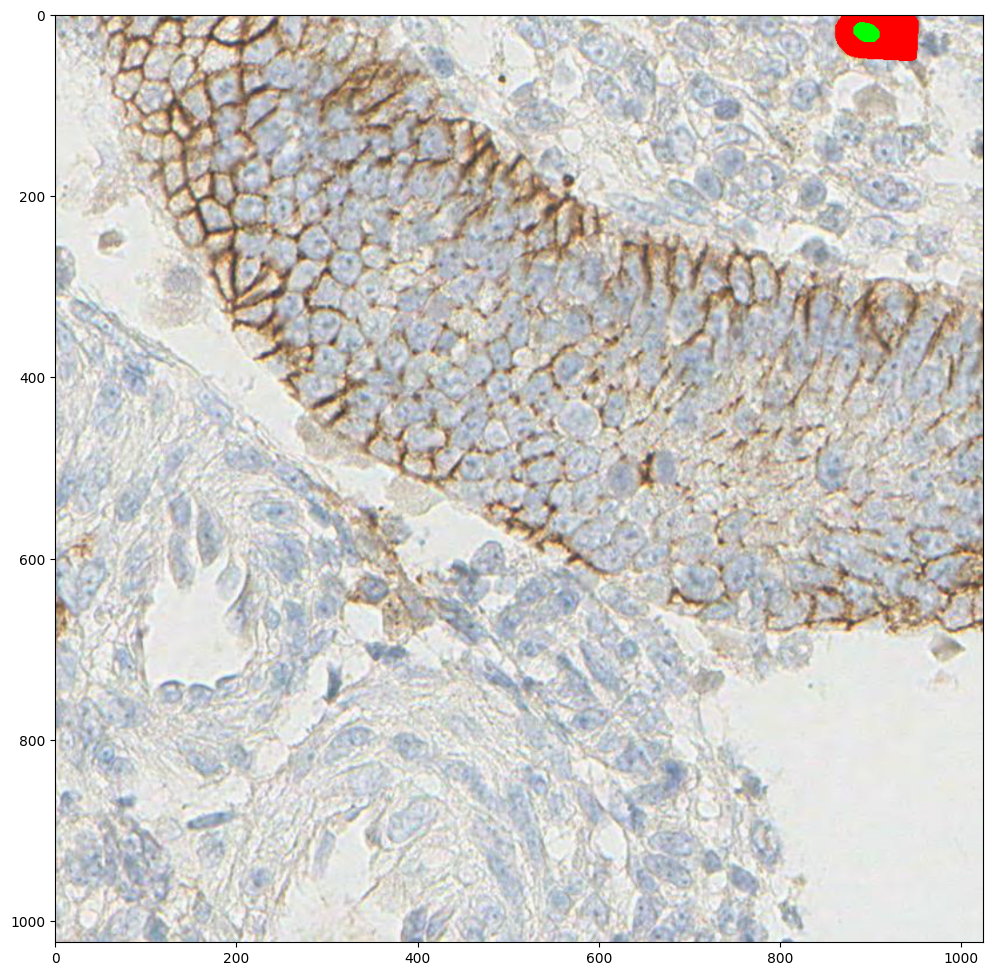

In [13]:
convex_hull_for_showing(converted_images, "no path to save")

In [14]:
import numpy as np
import copy


def is_close_enough(true_value_coord, pred_value_coord, threshold=14):
    x_diff = abs(true_value_coord[0] - pred_value_coord[0])
    y_diff = abs(true_value_coord[1] - pred_value_coord[1])
    return x_diff <= threshold and y_diff <= threshold


def calculate_tp_fp_fn_current_pic(true_values, predicted_values):
    num_true = len(true_values)
    num_predicted = len(predicted_values)
    tp = 0
    fp = 0
    fn = 0
    matched_true_values = set()

    for pred in predicted_values:
        found_match = False
        for true_value in true_values:
            if is_close_enough(true_value, pred) and true_value not in matched_true_values:
                tp += 1
                matched_true_values.add(true_value)
                found_match = True
                break
        if not found_match:
            fp += 1

    if (num_true != 0):
        fn = num_true - tp

    return tp, fp, fn


def get_precision_and_recall(algo_image_dict, result_dict):
    precision = 0.0
    recall = 0.0
    tp = 0.0
    fp = 0.0
    fn = 0.0
    for key in algo_image_dict:
        true_values = result_dict[key]
        predicted_values = algo_image_dict[key]
        if (len(true_values) > 0  or len(predicted_values) > 0):
            curr_tp, curr_fp, curr_fn = calculate_tp_fp_fn_current_pic(true_values, predicted_values)
            tp += curr_tp
            fp += curr_fp
            fn += curr_fn
            
    if (tp != 0 or fp != 0):
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = 2 * tp / (2 * tp + fp + fn)

    return precision, recall, f1


copy_algo_image_dict = copy.deepcopy(algo_image_dict)
copy_result_dict = copy.deepcopy(result_dict)
precision, recall, f1 = get_precision_and_recall(copy_algo_image_dict, copy_result_dict)
print ("precision, recall, f1 score")
print (precision, recall, f1)

precision, recall, f1 score
0.8414634146341463 0.7582417582417582 0.7976878612716763
